# Build binary classification models that use PCA components

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef
pd.set_option('display.max_columns', None)

## Preprocessing

In [4]:
df = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")

#replace categorical feature with index labeling
df['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

#differentiate other categorical features from the numerical ones
pheno = df.loc[:,'RID':'VISCODE']
data = df.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']

## Normalization

#normally test function -> check if each column is normally distr
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    count=0
    for i in p:
        if i > alpha:  # null hypothesis: x comes from a normal distribution
            count+=1
    print('There are ',count,'normally distributed features out of',data.shape[1])

#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0),index=df.index,columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# compute quantile normalized data
df_qn=quantile_normalize(data)
data = df_qn

#Scale the data to the range between 0 and 1 before using PCA
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data)

## Split dataset
X = data_rescaled
y = df["binary_class"]

## Test models using with PCA as feature selection

In [12]:
# Make an instance of the model keeping 95% of the features variance
pca = PCA(0.8)
# pca = PCA(n_components=100)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
print('Note that we now have',principalDf.shape[1],'columns instead of',X.shape[1])

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(principalDf, y, test_size = 0.20, random_state = 97, stratify = y)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(principalDf, y, test_size = 0.40, random_state = 97, stratify = y)

Note that we now have 13 columns instead of 320


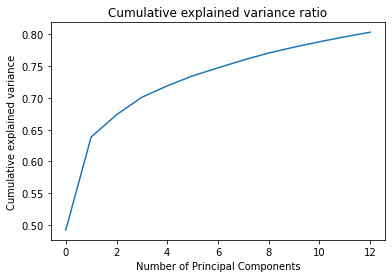

In [13]:
PC_values = np.arange(pca.n_components_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative explained variance ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative explained variance');

### Single xgb classifier

In [15]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))

In [14]:
print('Using 20% testing subset:')
XGB_class(X_train_20,X_test_20,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)
print('Using 40% testing subset:')
XGB_class(X_train_40,X_test_40,y_train_40,y_test_40,0,0,0,0,0,0,0,simple=True)

Using 20% testing subset
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.63      0.71      0.67        17

    accuracy                           0.56        27
   macro avg       0.50      0.50      0.50        27
weighted avg       0.54      0.56      0.54        27

Accuracy: 0.5555555555555556
MCC = 0.006220907522417994
Using 40% testing subset
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        21
           1       0.67      0.73      0.70        33

    accuracy                           0.61        54
   macro avg       0.58      0.58      0.58        54
weighted avg       0.60      0.61      0.60        54

Accuracy: 0.6111111111111112
MCC = 0.16116459280507606


### SVM

In [15]:
def SVM_class(X_train,X_test,y_train,y_test):
    clf = SVC(kernel='linear') 
    clf.fit(X_train, y_train) 
    y_predicted = clf.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))

In [17]:
print('Using 20% testing subset:')
SVM_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% testing subset:')
SVM_class(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% testing subset:
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.72      0.76      0.74        17

    accuracy                           0.67        27
   macro avg       0.64      0.63      0.63        27
weighted avg       0.66      0.67      0.66        27

Accuracy: 0.6666666666666666
MCC = 0.27116307227332026
Using 40% testing subset:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56        21
           1       0.72      0.85      0.78        33

    accuracy                           0.70        54
   macro avg       0.69      0.66      0.67        54
weighted avg       0.70      0.70      0.69        54

Accuracy: 0.7037037037037037
MCC = 0.3533767463701098


### Single Random Forest classifier

In [18]:
def SRF_class(X_train,X_test,y_train,y_test):
    model = RandomForestClassifier().fit(X_train,y_train)
    y_predicted = model.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))

In [19]:
print('Using 20% testing subset:')
SRF_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% testing subset:')
SRF_class(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% testing subset:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25        10
           1       0.62      0.76      0.68        17

    accuracy                           0.56        27
   macro avg       0.48      0.48      0.47        27
weighted avg       0.51      0.56      0.52        27

Accuracy: 0.5555555555555556
MCC = -0.04099600308453939
Using 40% testing subset:
              precision    recall  f1-score   support

           0       0.67      0.29      0.40        21
           1       0.67      0.91      0.77        33

    accuracy                           0.67        54
   macro avg       0.67      0.60      0.58        54
weighted avg       0.67      0.67      0.63        54

Accuracy: 0.6666666666666666
MCC = 0.25482359571881275


### Logistic Regression

In [20]:
def LR_class(X_train,X_test,y_train,y_test):
    model = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_predicted = model.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))

In [21]:
print('Using 20% testing subset:')
LR_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% testing subset:')
LR_class(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% testing subset:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.68      0.76      0.72        17

    accuracy                           0.63        27
   macro avg       0.59      0.58      0.58        27
weighted avg       0.62      0.63      0.62        27

Accuracy: 0.6296296296296297
MCC = 0.17418541062770382
Using 40% testing subset:
              precision    recall  f1-score   support

           0       0.69      0.52      0.59        21
           1       0.74      0.85      0.79        33

    accuracy                           0.72        54
   macro avg       0.71      0.69      0.69        54
weighted avg       0.72      0.72      0.71        54

Accuracy: 0.7222222222222222
MCC = 0.3974672033225129


### Test which PCA variance is the best for XGBoost classifier model

In [7]:
variances = np.arange(0.5, 0.99, 0.01).tolist()
nbr_tests = 2

# Creates a list containing 5 lists, each of 8 items, all set to 0
w, h = nbr_tests, len(variances)
perf = [[0 for x in range(w)] for y in range(h)] 

for i in range(nbr_tests):
    for j in range(len(variances)):
        pca = PCA(variances[j])

        principalComponents = pca.fit_transform(X)
        principalDf = pd.DataFrame(data = principalComponents)

        X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size = 0.20)

        clf = xgb.XGBClassifier(random_state = random.randint(0,nbr_tests),use_label_encoder =False)
        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)

        acc = accuracy_score(y_test, y_predicted) 
        perf[j][i] = acc

avg_perf = []
for i in range(len(perf)):
    avg_perf.append(sum(perf[i]) / len(perf[i]))

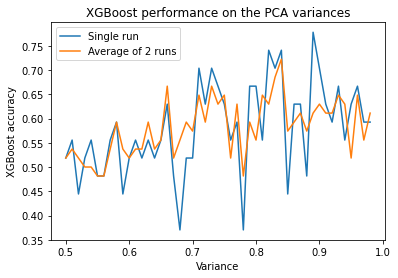

So best variance with the XGBoost Classifier model is 0.8


In [9]:
plt.plot(variances, [item[0] for item in perf])
plt.plot(variances, avg_perf)
plt.xlabel('Variance') 
plt.ylabel('XGBoost accuracy') 
plt.title("XGBoost performance on the PCA variances")
plt.legend(['Single run',('Average of '+str(nbr_tests)+' runs')])
plt.show()
print("So best variance with the XGBoost Classifier model is 0.8")

## test with strong model

In [11]:
## Hyperparameter tuning XGBoost classifier

random.seed(723)
np.random.seed(723)

def initilialize_poplulation(numberOfParents):
    learningRate = np.empty([numberOfParents, 1])
    nEstimators = np.empty([numberOfParents, 1], dtype = np.uint8)
    maxDepth = np.empty([numberOfParents, 1], dtype = np.uint8)
    minChildWeight = np.empty([numberOfParents, 1])
    gammaValue = np.empty([numberOfParents, 1])
    subSample = np.empty([numberOfParents, 1])
    colSampleByTree =  np.empty([numberOfParents, 1])

    for i in range(numberOfParents):
        learningRate[i] = round(random.uniform(0.01, 1), 2)
        nEstimators[i] = random.randrange(10, 1500, step = 25)
        maxDepth[i] = int(random.randrange(1, 10, step= 1))
        minChildWeight[i] = round(random.uniform(0.01, 10.0), 2)
        gammaValue[i] = round(random.uniform(0.01, 10.0), 2)
        subSample[i] = round(random.uniform(0.01, 1.0), 2)
        colSampleByTree[i] = round(random.uniform(0.01, 1.0), 2)
    
    population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree), axis= 1)
    return population

   

def fitness_accuracy_score(y_true, y_pred):
    fitness = round((accuracy_score(y_true, y_pred)), 4)
    return fitness

def train_population(population, dMatrixTrain, dMatrixtest, y_test):
    aScore = []
    for i in range(population.shape[0]):
        param = { 'objective':'binary:logistic',
              'learning_rate': population[i][0],
              'n_estimators': population[i][1], 
              'max_depth': int(population[i][2]), 
              'min_child_weight': population[i][3],
              'gamma': population[i][4], 
              'subsample': population[i][5],
              'colsample_bytree': population[i][6],
              'seed': 24}
        num_round = 100
        xgbT = xgb.train(param, dMatrixTrain, num_round)
        preds = xgbT.predict(dMatrixtest)
        preds = preds>0.5
        aScore.append(fitness_accuracy_score(y_test, preds))
    return aScore



def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) 
    
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 
    return selectedParents
        

def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8)
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) 
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) 
    
    children = np.empty(childrenSize)
    
    
    for i in range(childrenSize[0]):
        
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
    return children
    


def mutation(crossover, numberOfParameters):

    minMaxValue = np.zeros((numberOfParameters, 2))
    
    minMaxValue[0:] = [0.01, 1.0] 
    minMaxValue[1, :] = [10, 2000] 
    minMaxValue[2, :] = [1, 15] 
    minMaxValue[3, :] = [0, 10.0] 
    minMaxValue[4, :] = [0.01, 10.0] 
    minMaxValue[5, :] = [0.01, 1.0] 
    minMaxValue[6, :] = [0.01, 1.0] 
 
    
    mutationValue = 0
    parameterSelect = np.random.randint(0, 7, 1)
    print(parameterSelect)
    if parameterSelect == 0: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 1: 
        mutationValue = np.random.randint(-200, 200, 1)
    if parameterSelect == 2:
        mutationValue = np.random.randint(-5, 5, 1)
    if parameterSelect == 3: 
        mutationValue = round(np.random.uniform(5, 5), 2)
    if parameterSelect == 4: 
        mutationValue = round(np.random.uniform(-2, 2), 2)
    if parameterSelect == 5: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 6: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
    
    for idx in range(crossover.shape[0]):
        crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
        if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
        if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]    
    return crossover

def hyp_param_ev_algo(X_train, y_train):
    
    hyp_X_train, hyp_X_test, hyp_y_train, hyp_y_test = train_test_split(X_train, y_train, test_size = 0.80, random_state = 97,stratify=y_train)

    xgDMatrix = xgb.DMatrix(hyp_X_train, hyp_y_train) 
    xgbDMatrixTest = xgb.DMatrix(hyp_X_test, hyp_y_test)

    numberOfParents = 100 
    numberOfParentsMating = int(numberOfParents/2)
    numberOfParameters = 7 
    numberOfGenerations = 5

    populationSize = (numberOfParents, numberOfParameters)
    population = initilialize_poplulation(numberOfParents)

    fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])
    populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])
    populationHistory[0:numberOfParents, :] = population

    for generation in range(numberOfGenerations):
        
        fitnessValue = train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=hyp_y_test)
        fitnessHistory[generation, :] = fitnessValue

        print('Best Iteration',generation ,'Accuracy on train set = {}'.format(np.max(fitnessHistory[generation, :])))

        parents = new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
        children = crossover_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))
        children_mutated = mutation(children, numberOfParameters)

        population[0:parents.shape[0], :] = parents 
        population[parents.shape[0]:, :] = children_mutated 

        populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population 

    fitness = train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=hyp_y_test)
    fitnessHistory[generation+1, :] = fitness

    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

    print("Best fitness is =", fitness[bestFitnessIndex])


    print("Best parameters are:")
    print('learning_rate', population[bestFitnessIndex][0])
    print('n_estimators', population[bestFitnessIndex][1])
    print('max_depth', int(population[bestFitnessIndex][2])) 
    print('min_child_weight', population[bestFitnessIndex][3])
    print('gamma', population[bestFitnessIndex][4])
    print('subsample', population[bestFitnessIndex][5])
    print('colsample_bytree', population[bestFitnessIndex][6])
    
    return population[bestFitnessIndex][0],population[bestFitnessIndex][1],population[bestFitnessIndex][2],population[bestFitnessIndex][3],population[bestFitnessIndex][4],population[bestFitnessIndex][5],population[bestFitnessIndex][6]

In [16]:
#test RFE with tuning XGB hyperparameters
learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree = hyp_param_ev_algo(X_train, y_train)
XGB_class(X_train,X_test,y_train,y_test,learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree,simple=False)

              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.67      0.75      0.71        16

    accuracy                           0.63        27
   macro avg       0.61      0.60      0.60        27
weighted avg       0.62      0.63      0.62        27

Accuracy: 0.6296296296296297
MCC = 0.21320071635561041
